# 네이버 영화 리뷰 감성 분류
- 출처: [WikiDocs](https://wikidocs.net/44249)
- 데이터 다운로드 링크: https://github.com/e9t/nsmc/

## 1. 네이버 영화 리뷰 데이터에 대한 이해

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
train_data= pd.read_table('data/ratings_train.txt')
test_data= pd.read_table('data/ratings_test.txt')

C:\Users\EZEN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
C:\Users\EZEN\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [4]:
# 영화 리뷰 개수
len(train_data), len(test_data)

(150000, 50000)

In [5]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


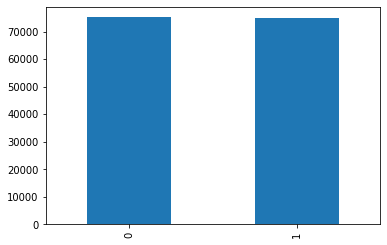

In [7]:
# 0 - 부정, 1 - 긍정
train_data['label'].value_counts().plot(kind='bar')

In [8]:
train_data['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [9]:
# 리뷰 중에 Null 값을 가진 샘플이 있는지 확인
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

True
True


In [10]:
# 어떤 열에 존재하는지 확인
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64


In [11]:
print(test_data.isnull().sum())

id          0
document    3
label       0
dtype: int64


In [12]:
# Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [13]:
# Null 값을 가진 샘플을 제거
train_data=train_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [14]:
test_data=test_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


## 2. 전처리

In [15]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [16]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [17]:
# 토큰화와 불용어 제거
from tqdm import tqdm_notebook
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train=[]
for sentence in tqdm_notebook(train_data['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

C:\Users\EZEN\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [18]:
X_test=[]
for sentence in tqdm_notebook(test_data['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [19]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [20]:
# 정수 인코딩
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [21]:
X_train[:3]

[[50, 457, 16, 260, 660],
 [919, 459, 41, 599, 1, 214, 1455, 24, 965, 676, 19],
 [386, 2452, 25024, 2319, 5676, 2, 221, 9]]

In [22]:
# 전체 데이터의 길이 분포
print('리뷰의 최대 길이 :', max(len(s) for s in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.64700156671889


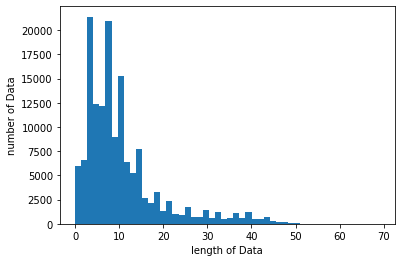

In [23]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [24]:
#  X_train과 X_test의 모든 샘플의 길이를 동일하게 30으로 셋팅
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [25]:
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

## 3. LSTM으로 감성 분류하기

In [26]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [27]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3500000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,617,377
Trainable params: 3,617,377
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelpath = "model/naver-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [30]:
history = model.fit(X_train, y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=2, callbacks=[checkpointer])

Train on 119996 samples, validate on 29999 samples
Epoch 1/4


 12180/119996 [==>...........................] - ETA: 58:36 - loss: 0.6937 - acc: 0.41 - ETA: 30:27 - loss: 0.6943 - acc: 0.47 - ETA: 21:01 - loss: 0.6947 - acc: 0.47 - ETA: 16:16 - loss: 0.6937 - acc: 0.51 - ETA: 13:26 - loss: 0.6932 - acc: 0.52 - ETA: 11:34 - loss: 0.6927 - acc: 0.53 - ETA: 10:13 - loss: 0.6926 - acc: 0.53 - ETA: 9:13 - loss: 0.6921 - acc: 0.5583 - ETA: 8:26 - loss: 0.6916 - acc: 0.563 - ETA: 7:49 - loss: 0.6911 - acc: 0.580 - ETA: 7:19 - loss: 0.6906 - acc: 0.578 - ETA: 6:53 - loss: 0.6899 - acc: 0.581 - ETA: 6:31 - loss: 0.6901 - acc: 0.576 - ETA: 6:12 - loss: 0.6893 - acc: 0.581 - ETA: 5:56 - loss: 0.6883 - acc: 0.582 - ETA: 5:42 - loss: 0.6866 - acc: 0.583 - ETA: 5:29 - loss: 0.6856 - acc: 0.580 - ETA: 5:18 - loss: 0.6838 - acc: 0.582 - ETA: 5:08 - loss: 0.6807 - acc: 0.585 - ETA: 4:59 - loss: 0.7104 - acc: 0.586 - ETA: 4:51 - loss: 0.7079 - acc: 0.592 - ETA: 4:43 - loss: 0.7047 - acc: 0.600 - ETA: 4:36 - loss: 0.7023 - acc: 0.607 - ETA: 4:30 - loss: 0.7015 - acc

 48900/119996 [===========>..................] - ETA: 1:35 - loss: 0.4433 - acc: 0.794 - ETA: 1:35 - loss: 0.4431 - acc: 0.794 - ETA: 1:35 - loss: 0.4430 - acc: 0.794 - ETA: 1:35 - loss: 0.4428 - acc: 0.794 - ETA: 1:35 - loss: 0.4428 - acc: 0.794 - ETA: 1:35 - loss: 0.4428 - acc: 0.794 - ETA: 1:35 - loss: 0.4429 - acc: 0.794 - ETA: 1:35 - loss: 0.4430 - acc: 0.794 - ETA: 1:35 - loss: 0.4430 - acc: 0.794 - ETA: 1:35 - loss: 0.4431 - acc: 0.794 - ETA: 1:34 - loss: 0.4429 - acc: 0.794 - ETA: 1:34 - loss: 0.4428 - acc: 0.794 - ETA: 1:34 - loss: 0.4428 - acc: 0.794 - ETA: 1:34 - loss: 0.4430 - acc: 0.794 - ETA: 1:34 - loss: 0.4429 - acc: 0.794 - ETA: 1:34 - loss: 0.4429 - acc: 0.794 - ETA: 1:34 - loss: 0.4428 - acc: 0.794 - ETA: 1:34 - loss: 0.4427 - acc: 0.794 - ETA: 1:34 - loss: 0.4426 - acc: 0.794 - ETA: 1:34 - loss: 0.4423 - acc: 0.794 - ETA: 1:34 - loss: 0.4423 - acc: 0.794 - ETA: 1:34 - loss: 0.4424 - acc: 0.794 - ETA: 1:33 - loss: 0.4423 - acc: 0.794 - ETA: 1:33 - loss: 0.4421 - acc:

 61140/119996 [==============>...............] - ETA: 1:20 - loss: 0.4281 - acc: 0.801 - ETA: 1:20 - loss: 0.4280 - acc: 0.801 - ETA: 1:20 - loss: 0.4278 - acc: 0.802 - ETA: 1:20 - loss: 0.4277 - acc: 0.802 - ETA: 1:20 - loss: 0.4275 - acc: 0.802 - ETA: 1:19 - loss: 0.4273 - acc: 0.802 - ETA: 1:19 - loss: 0.4272 - acc: 0.802 - ETA: 1:19 - loss: 0.4272 - acc: 0.802 - ETA: 1:19 - loss: 0.4270 - acc: 0.802 - ETA: 1:19 - loss: 0.4271 - acc: 0.802 - ETA: 1:19 - loss: 0.4270 - acc: 0.802 - ETA: 1:19 - loss: 0.4270 - acc: 0.802 - ETA: 1:19 - loss: 0.4270 - acc: 0.802 - ETA: 1:19 - loss: 0.4270 - acc: 0.802 - ETA: 1:19 - loss: 0.4270 - acc: 0.802 - ETA: 1:19 - loss: 0.4270 - acc: 0.802 - ETA: 1:19 - loss: 0.4269 - acc: 0.802 - ETA: 1:19 - loss: 0.4268 - acc: 0.802 - ETA: 1:19 - loss: 0.4266 - acc: 0.802 - ETA: 1:18 - loss: 0.4265 - acc: 0.802 - ETA: 1:18 - loss: 0.4265 - acc: 0.802 - ETA: 1:18 - loss: 0.4265 - acc: 0.802 - ETA: 1:18 - loss: 0.4263 - acc: 0.802 - ETA: 1:18 - loss: 0.4263 - acc:

 73740/119996 [=================>............] - ETA: 1:06 - loss: 0.4170 - acc: 0.807 - ETA: 1:05 - loss: 0.4170 - acc: 0.807 - ETA: 1:05 - loss: 0.4169 - acc: 0.807 - ETA: 1:05 - loss: 0.4168 - acc: 0.807 - ETA: 1:05 - loss: 0.4168 - acc: 0.807 - ETA: 1:05 - loss: 0.4166 - acc: 0.807 - ETA: 1:05 - loss: 0.4165 - acc: 0.807 - ETA: 1:05 - loss: 0.4166 - acc: 0.807 - ETA: 1:05 - loss: 0.4166 - acc: 0.807 - ETA: 1:05 - loss: 0.4166 - acc: 0.807 - ETA: 1:05 - loss: 0.4167 - acc: 0.807 - ETA: 1:05 - loss: 0.4167 - acc: 0.807 - ETA: 1:05 - loss: 0.4167 - acc: 0.807 - ETA: 1:05 - loss: 0.4167 - acc: 0.807 - ETA: 1:05 - loss: 0.4167 - acc: 0.807 - ETA: 1:05 - loss: 0.4169 - acc: 0.807 - ETA: 1:05 - loss: 0.4169 - acc: 0.807 - ETA: 1:04 - loss: 0.4167 - acc: 0.807 - ETA: 1:04 - loss: 0.4168 - acc: 0.807 - ETA: 1:04 - loss: 0.4168 - acc: 0.807 - ETA: 1:04 - loss: 0.4167 - acc: 0.807 - ETA: 1:04 - loss: 0.4166 - acc: 0.807 - ETA: 1:04 - loss: 0.4164 - acc: 0.807 - ETA: 1:04 - loss: 0.4164 - acc:

 86640/119996 [====================>.........] - ETA: 51s - loss: 0.4106 - acc: 0.81 - ETA: 51s - loss: 0.4106 - acc: 0.81 - ETA: 51s - loss: 0.4107 - acc: 0.81 - ETA: 51s - loss: 0.4107 - acc: 0.81 - ETA: 51s - loss: 0.4106 - acc: 0.81 - ETA: 51s - loss: 0.4105 - acc: 0.81 - ETA: 51s - loss: 0.4105 - acc: 0.81 - ETA: 51s - loss: 0.4104 - acc: 0.81 - ETA: 51s - loss: 0.4104 - acc: 0.81 - ETA: 51s - loss: 0.4104 - acc: 0.81 - ETA: 51s - loss: 0.4104 - acc: 0.81 - ETA: 50s - loss: 0.4102 - acc: 0.81 - ETA: 50s - loss: 0.4101 - acc: 0.81 - ETA: 50s - loss: 0.4101 - acc: 0.81 - ETA: 50s - loss: 0.4101 - acc: 0.81 - ETA: 50s - loss: 0.4102 - acc: 0.81 - ETA: 50s - loss: 0.4101 - acc: 0.81 - ETA: 50s - loss: 0.4101 - acc: 0.81 - ETA: 50s - loss: 0.4100 - acc: 0.81 - ETA: 50s - loss: 0.4100 - acc: 0.81 - ETA: 50s - loss: 0.4100 - acc: 0.81 - ETA: 50s - loss: 0.4100 - acc: 0.81 - ETA: 50s - loss: 0.4099 - acc: 0.81 - ETA: 50s - loss: 0.4098 - acc: 0.81 - ETA: 50s - loss: 0.4098 - acc: 0.81 - E

 99540/119996 [=======================>......] - ETA: 37s - loss: 0.4037 - acc: 0.81 - ETA: 37s - loss: 0.4037 - acc: 0.81 - ETA: 36s - loss: 0.4036 - acc: 0.81 - ETA: 36s - loss: 0.4035 - acc: 0.81 - ETA: 36s - loss: 0.4035 - acc: 0.81 - ETA: 36s - loss: 0.4034 - acc: 0.81 - ETA: 36s - loss: 0.4033 - acc: 0.81 - ETA: 36s - loss: 0.4033 - acc: 0.81 - ETA: 36s - loss: 0.4033 - acc: 0.81 - ETA: 36s - loss: 0.4034 - acc: 0.81 - ETA: 36s - loss: 0.4034 - acc: 0.81 - ETA: 36s - loss: 0.4033 - acc: 0.81 - ETA: 36s - loss: 0.4033 - acc: 0.81 - ETA: 36s - loss: 0.4033 - acc: 0.81 - ETA: 36s - loss: 0.4032 - acc: 0.81 - ETA: 36s - loss: 0.4030 - acc: 0.81 - ETA: 35s - loss: 0.4030 - acc: 0.81 - ETA: 35s - loss: 0.4029 - acc: 0.81 - ETA: 35s - loss: 0.4030 - acc: 0.81 - ETA: 35s - loss: 0.4030 - acc: 0.81 - ETA: 35s - loss: 0.4029 - acc: 0.81 - ETA: 35s - loss: 0.4029 - acc: 0.81 - ETA: 35s - loss: 0.4029 - acc: 0.81 - ETA: 35s - loss: 0.4028 - acc: 0.81 - ETA: 35s - loss: 0.4028 - acc: 0.81 - E

112440/119996 [===========================>..] - ETA: 22s - loss: 0.3978 - acc: 0.81 - ETA: 22s - loss: 0.3978 - acc: 0.81 - ETA: 22s - loss: 0.3978 - acc: 0.81 - ETA: 22s - loss: 0.3978 - acc: 0.81 - ETA: 22s - loss: 0.3978 - acc: 0.81 - ETA: 22s - loss: 0.3977 - acc: 0.81 - ETA: 22s - loss: 0.3978 - acc: 0.81 - ETA: 22s - loss: 0.3977 - acc: 0.81 - ETA: 22s - loss: 0.3978 - acc: 0.81 - ETA: 22s - loss: 0.3978 - acc: 0.81 - ETA: 21s - loss: 0.3978 - acc: 0.81 - ETA: 21s - loss: 0.3977 - acc: 0.81 - ETA: 21s - loss: 0.3977 - acc: 0.81 - ETA: 21s - loss: 0.3977 - acc: 0.81 - ETA: 21s - loss: 0.3976 - acc: 0.81 - ETA: 21s - loss: 0.3976 - acc: 0.81 - ETA: 21s - loss: 0.3976 - acc: 0.81 - ETA: 21s - loss: 0.3976 - acc: 0.81 - ETA: 21s - loss: 0.3976 - acc: 0.81 - ETA: 21s - loss: 0.3976 - acc: 0.81 - ETA: 21s - loss: 0.3977 - acc: 0.81 - ETA: 21s - loss: 0.3976 - acc: 0.81 - ETA: 21s - loss: 0.3977 - acc: 0.81 - ETA: 21s - loss: 0.3977 - acc: 0.81 - ETA: 21s - loss: 0.3976 - acc: 0.81 - E

119940/119996 [============================>.] - ETA: 8s - loss: 0.3933 - acc: 0.820 - ETA: 8s - loss: 0.3932 - acc: 0.820 - ETA: 8s - loss: 0.3932 - acc: 0.820 - ETA: 8s - loss: 0.3931 - acc: 0.820 - ETA: 8s - loss: 0.3931 - acc: 0.820 - ETA: 7s - loss: 0.3931 - acc: 0.820 - ETA: 7s - loss: 0.3930 - acc: 0.820 - ETA: 7s - loss: 0.3930 - acc: 0.820 - ETA: 7s - loss: 0.3930 - acc: 0.820 - ETA: 7s - loss: 0.3930 - acc: 0.820 - ETA: 7s - loss: 0.3929 - acc: 0.820 - ETA: 7s - loss: 0.3929 - acc: 0.820 - ETA: 7s - loss: 0.3929 - acc: 0.821 - ETA: 7s - loss: 0.3929 - acc: 0.820 - ETA: 7s - loss: 0.3929 - acc: 0.821 - ETA: 7s - loss: 0.3929 - acc: 0.821 - ETA: 7s - loss: 0.3930 - acc: 0.821 - ETA: 7s - loss: 0.3929 - acc: 0.821 - ETA: 7s - loss: 0.3929 - acc: 0.821 - ETA: 7s - loss: 0.3929 - acc: 0.821 - ETA: 6s - loss: 0.3928 - acc: 0.821 - ETA: 6s - loss: 0.3928 - acc: 0.821 - ETA: 6s - loss: 0.3927 - acc: 0.821 - ETA: 6s - loss: 0.3927 - acc: 0.821 - ETA: 6s - loss: 0.3927 - acc: 0.821 - E

 12240/119996 [==>...........................] - ETA: 2:09 - loss: 0.3150 - acc: 0.883 - ETA: 2:09 - loss: 0.2453 - acc: 0.908 - ETA: 2:14 - loss: 0.2866 - acc: 0.894 - ETA: 2:12 - loss: 0.3224 - acc: 0.875 - ETA: 2:11 - loss: 0.3331 - acc: 0.853 - ETA: 2:11 - loss: 0.3522 - acc: 0.850 - ETA: 2:11 - loss: 0.3495 - acc: 0.852 - ETA: 2:10 - loss: 0.3689 - acc: 0.845 - ETA: 2:11 - loss: 0.3619 - acc: 0.851 - ETA: 2:11 - loss: 0.3627 - acc: 0.850 - ETA: 2:11 - loss: 0.3575 - acc: 0.851 - ETA: 2:10 - loss: 0.3531 - acc: 0.851 - ETA: 2:10 - loss: 0.3496 - acc: 0.851 - ETA: 2:10 - loss: 0.3441 - acc: 0.853 - ETA: 2:10 - loss: 0.3418 - acc: 0.852 - ETA: 2:10 - loss: 0.3323 - acc: 0.858 - ETA: 2:10 - loss: 0.3283 - acc: 0.859 - ETA: 2:09 - loss: 0.3277 - acc: 0.856 - ETA: 2:09 - loss: 0.3238 - acc: 0.858 - ETA: 2:09 - loss: 0.3266 - acc: 0.857 - ETA: 2:09 - loss: 0.3351 - acc: 0.854 - ETA: 2:08 - loss: 0.3386 - acc: 0.856 - ETA: 2:08 - loss: 0.3399 - acc: 0.856 - ETA: 2:08 - loss: 0.3411 - acc:

 48960/119996 [===========>..................] - ETA: 1:31 - loss: 0.3313 - acc: 0.854 - ETA: 1:31 - loss: 0.3311 - acc: 0.854 - ETA: 1:31 - loss: 0.3311 - acc: 0.854 - ETA: 1:31 - loss: 0.3310 - acc: 0.854 - ETA: 1:31 - loss: 0.3309 - acc: 0.854 - ETA: 1:31 - loss: 0.3309 - acc: 0.854 - ETA: 1:31 - loss: 0.3309 - acc: 0.854 - ETA: 1:31 - loss: 0.3307 - acc: 0.854 - ETA: 1:31 - loss: 0.3305 - acc: 0.855 - ETA: 1:31 - loss: 0.3306 - acc: 0.854 - ETA: 1:30 - loss: 0.3306 - acc: 0.854 - ETA: 1:30 - loss: 0.3306 - acc: 0.854 - ETA: 1:30 - loss: 0.3307 - acc: 0.854 - ETA: 1:30 - loss: 0.3306 - acc: 0.854 - ETA: 1:30 - loss: 0.3307 - acc: 0.854 - ETA: 1:30 - loss: 0.3306 - acc: 0.855 - ETA: 1:30 - loss: 0.3306 - acc: 0.855 - ETA: 1:30 - loss: 0.3307 - acc: 0.855 - ETA: 1:30 - loss: 0.3308 - acc: 0.854 - ETA: 1:30 - loss: 0.3308 - acc: 0.854 - ETA: 1:30 - loss: 0.3307 - acc: 0.854 - ETA: 1:30 - loss: 0.3305 - acc: 0.855 - ETA: 1:30 - loss: 0.3304 - acc: 0.855 - ETA: 1:30 - loss: 0.3301 - acc:

 61200/119996 [==============>...............] - ETA: 1:17 - loss: 0.3305 - acc: 0.854 - ETA: 1:17 - loss: 0.3305 - acc: 0.854 - ETA: 1:17 - loss: 0.3305 - acc: 0.854 - ETA: 1:17 - loss: 0.3307 - acc: 0.854 - ETA: 1:17 - loss: 0.3307 - acc: 0.854 - ETA: 1:17 - loss: 0.3307 - acc: 0.854 - ETA: 1:17 - loss: 0.3307 - acc: 0.854 - ETA: 1:17 - loss: 0.3308 - acc: 0.854 - ETA: 1:17 - loss: 0.3309 - acc: 0.854 - ETA: 1:17 - loss: 0.3308 - acc: 0.854 - ETA: 1:16 - loss: 0.3309 - acc: 0.854 - ETA: 1:16 - loss: 0.3309 - acc: 0.854 - ETA: 1:16 - loss: 0.3309 - acc: 0.854 - ETA: 1:16 - loss: 0.3311 - acc: 0.854 - ETA: 1:16 - loss: 0.3310 - acc: 0.854 - ETA: 1:16 - loss: 0.3310 - acc: 0.854 - ETA: 1:16 - loss: 0.3309 - acc: 0.854 - ETA: 1:16 - loss: 0.3309 - acc: 0.854 - ETA: 1:16 - loss: 0.3310 - acc: 0.854 - ETA: 1:16 - loss: 0.3309 - acc: 0.854 - ETA: 1:16 - loss: 0.3311 - acc: 0.854 - ETA: 1:16 - loss: 0.3311 - acc: 0.854 - ETA: 1:16 - loss: 0.3311 - acc: 0.854 - ETA: 1:16 - loss: 0.3311 - acc:

 73920/119996 [=================>............] - ETA: 1:03 - loss: 0.3306 - acc: 0.855 - ETA: 1:03 - loss: 0.3305 - acc: 0.855 - ETA: 1:03 - loss: 0.3304 - acc: 0.855 - ETA: 1:03 - loss: 0.3304 - acc: 0.855 - ETA: 1:03 - loss: 0.3305 - acc: 0.855 - ETA: 1:03 - loss: 0.3305 - acc: 0.855 - ETA: 1:03 - loss: 0.3305 - acc: 0.855 - ETA: 1:03 - loss: 0.3305 - acc: 0.855 - ETA: 1:03 - loss: 0.3305 - acc: 0.855 - ETA: 1:03 - loss: 0.3304 - acc: 0.855 - ETA: 1:03 - loss: 0.3303 - acc: 0.855 - ETA: 1:03 - loss: 0.3303 - acc: 0.855 - ETA: 1:03 - loss: 0.3303 - acc: 0.855 - ETA: 1:03 - loss: 0.3304 - acc: 0.855 - ETA: 1:03 - loss: 0.3303 - acc: 0.855 - ETA: 1:02 - loss: 0.3305 - acc: 0.855 - ETA: 1:02 - loss: 0.3305 - acc: 0.855 - ETA: 1:02 - loss: 0.3305 - acc: 0.855 - ETA: 1:02 - loss: 0.3305 - acc: 0.855 - ETA: 1:02 - loss: 0.3304 - acc: 0.855 - ETA: 1:02 - loss: 0.3303 - acc: 0.855 - ETA: 1:02 - loss: 0.3303 - acc: 0.855 - ETA: 1:02 - loss: 0.3304 - acc: 0.855 - ETA: 1:02 - loss: 0.3303 - acc:

 86820/119996 [====================>.........] - ETA: 49s - loss: 0.3287 - acc: 0.85 - ETA: 49s - loss: 0.3287 - acc: 0.85 - ETA: 49s - loss: 0.3287 - acc: 0.85 - ETA: 49s - loss: 0.3287 - acc: 0.85 - ETA: 49s - loss: 0.3287 - acc: 0.85 - ETA: 49s - loss: 0.3287 - acc: 0.85 - ETA: 49s - loss: 0.3286 - acc: 0.85 - ETA: 49s - loss: 0.3286 - acc: 0.85 - ETA: 49s - loss: 0.3286 - acc: 0.85 - ETA: 49s - loss: 0.3286 - acc: 0.85 - ETA: 49s - loss: 0.3286 - acc: 0.85 - ETA: 49s - loss: 0.3287 - acc: 0.85 - ETA: 49s - loss: 0.3286 - acc: 0.85 - ETA: 49s - loss: 0.3285 - acc: 0.85 - ETA: 49s - loss: 0.3286 - acc: 0.85 - ETA: 48s - loss: 0.3286 - acc: 0.85 - ETA: 48s - loss: 0.3286 - acc: 0.85 - ETA: 48s - loss: 0.3287 - acc: 0.85 - ETA: 48s - loss: 0.3286 - acc: 0.85 - ETA: 48s - loss: 0.3286 - acc: 0.85 - ETA: 48s - loss: 0.3286 - acc: 0.85 - ETA: 48s - loss: 0.3287 - acc: 0.85 - ETA: 48s - loss: 0.3287 - acc: 0.85 - ETA: 48s - loss: 0.3286 - acc: 0.85 - ETA: 48s - loss: 0.3287 - acc: 0.85 - E

 99720/119996 [=======================>......] - ETA: 36s - loss: 0.3282 - acc: 0.85 - ETA: 35s - loss: 0.3281 - acc: 0.85 - ETA: 35s - loss: 0.3281 - acc: 0.85 - ETA: 35s - loss: 0.3280 - acc: 0.85 - ETA: 35s - loss: 0.3280 - acc: 0.85 - ETA: 35s - loss: 0.3279 - acc: 0.85 - ETA: 35s - loss: 0.3279 - acc: 0.85 - ETA: 35s - loss: 0.3280 - acc: 0.85 - ETA: 35s - loss: 0.3280 - acc: 0.85 - ETA: 35s - loss: 0.3279 - acc: 0.85 - ETA: 35s - loss: 0.3278 - acc: 0.85 - ETA: 35s - loss: 0.3277 - acc: 0.85 - ETA: 35s - loss: 0.3277 - acc: 0.85 - ETA: 35s - loss: 0.3276 - acc: 0.85 - ETA: 35s - loss: 0.3276 - acc: 0.85 - ETA: 35s - loss: 0.3275 - acc: 0.85 - ETA: 34s - loss: 0.3275 - acc: 0.85 - ETA: 34s - loss: 0.3275 - acc: 0.85 - ETA: 34s - loss: 0.3276 - acc: 0.85 - ETA: 34s - loss: 0.3277 - acc: 0.85 - ETA: 34s - loss: 0.3277 - acc: 0.85 - ETA: 34s - loss: 0.3277 - acc: 0.85 - ETA: 34s - loss: 0.3277 - acc: 0.85 - ETA: 34s - loss: 0.3278 - acc: 0.85 - ETA: 34s - loss: 0.3278 - acc: 0.85 - E

112620/119996 [===========================>..] - ETA: 22s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3282 - acc: 0.85 - ETA: 21s - loss: 0.3282 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3282 - acc: 0.85 - ETA: 21s - loss: 0.3281 - acc: 0.85 - ETA: 21s - loss: 0.3282 - acc: 0.85 - ETA: 20s - loss: 0.3282 - acc: 0.85 - ETA: 20s - loss: 0.3282 - acc: 0.85 - ETA: 20s - loss: 0.3281 - acc: 0.85 - ETA: 20s - loss: 0.3281 - acc: 0.85 - ETA: 20s - loss: 0.3280 - acc: 0.85 - ETA: 20s - loss: 0.3281 - acc: 0.85 - ETA: 20s - loss: 0.3281 - acc: 0.85 - ETA: 20s - loss: 0.3282 - acc: 0.85 - ETA: 20s - loss: 0.3282 - acc: 0.85 - E

119940/119996 [============================>.] - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 7s - loss: 0.3273 - acc: 0.856 - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 7s - loss: 0.3273 - acc: 0.856 - ETA: 7s - loss: 0.3273 - acc: 0.856 - ETA: 7s - loss: 0.3275 - acc: 0.856 - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 7s - loss: 0.3275 - acc: 0.856 - ETA: 7s - loss: 0.3274 - acc: 0.856 - ETA: 6s - loss: 0.3274 - acc: 0.856 - ETA: 6s - loss: 0.3275 - acc: 0.856 - ETA: 6s - loss: 0.3275 - acc: 0.856 - ETA: 6s - loss: 0.3275 - acc: 0.856 - ETA: 6s - loss: 0.3274 - acc: 0.856 - ETA: 6s - loss: 0.3275 - acc: 0.856 - ETA: 6s - loss: 0.3275 - acc: 0.856 - ETA: 6s - loss: 0.3276 - acc: 0.856 - ETA: 6s - loss: 0.3275 - acc: 0.856 - ETA: 6s - loss: 0.3275 - acc: 0.856 - E

 12240/119996 [==>...........................] - ETA: 2:11 - loss: 0.2795 - acc: 0.866 - ETA: 2:15 - loss: 0.2867 - acc: 0.883 - ETA: 2:14 - loss: 0.3197 - acc: 0.866 - ETA: 2:14 - loss: 0.2933 - acc: 0.879 - ETA: 2:13 - loss: 0.3331 - acc: 0.866 - ETA: 2:12 - loss: 0.3370 - acc: 0.850 - ETA: 2:11 - loss: 0.3370 - acc: 0.847 - ETA: 2:11 - loss: 0.3464 - acc: 0.847 - ETA: 2:10 - loss: 0.3296 - acc: 0.853 - ETA: 2:09 - loss: 0.3208 - acc: 0.856 - ETA: 2:09 - loss: 0.3271 - acc: 0.856 - ETA: 2:09 - loss: 0.3228 - acc: 0.858 - ETA: 2:09 - loss: 0.3258 - acc: 0.852 - ETA: 2:09 - loss: 0.3260 - acc: 0.854 - ETA: 2:09 - loss: 0.3313 - acc: 0.853 - ETA: 2:09 - loss: 0.3289 - acc: 0.854 - ETA: 2:10 - loss: 0.3239 - acc: 0.859 - ETA: 2:10 - loss: 0.3202 - acc: 0.862 - ETA: 2:10 - loss: 0.3228 - acc: 0.862 - ETA: 2:09 - loss: 0.3176 - acc: 0.865 - ETA: 2:09 - loss: 0.3155 - acc: 0.868 - ETA: 2:09 - loss: 0.3264 - acc: 0.864 - ETA: 2:09 - loss: 0.3279 - acc: 0.861 - ETA: 2:09 - loss: 0.3283 - acc:

 48960/119996 [===========>..................] - ETA: 1:31 - loss: 0.2972 - acc: 0.872 - ETA: 1:31 - loss: 0.2972 - acc: 0.872 - ETA: 1:30 - loss: 0.2972 - acc: 0.872 - ETA: 1:30 - loss: 0.2972 - acc: 0.872 - ETA: 1:30 - loss: 0.2970 - acc: 0.872 - ETA: 1:30 - loss: 0.2970 - acc: 0.872 - ETA: 1:30 - loss: 0.2971 - acc: 0.872 - ETA: 1:30 - loss: 0.2972 - acc: 0.872 - ETA: 1:30 - loss: 0.2973 - acc: 0.872 - ETA: 1:30 - loss: 0.2976 - acc: 0.872 - ETA: 1:30 - loss: 0.2977 - acc: 0.872 - ETA: 1:30 - loss: 0.2979 - acc: 0.872 - ETA: 1:30 - loss: 0.2982 - acc: 0.872 - ETA: 1:30 - loss: 0.2981 - acc: 0.872 - ETA: 1:30 - loss: 0.2981 - acc: 0.872 - ETA: 1:30 - loss: 0.2980 - acc: 0.872 - ETA: 1:29 - loss: 0.2979 - acc: 0.872 - ETA: 1:29 - loss: 0.2979 - acc: 0.872 - ETA: 1:29 - loss: 0.2979 - acc: 0.872 - ETA: 1:29 - loss: 0.2980 - acc: 0.872 - ETA: 1:29 - loss: 0.2981 - acc: 0.872 - ETA: 1:29 - loss: 0.2981 - acc: 0.872 - ETA: 1:29 - loss: 0.2981 - acc: 0.872 - ETA: 1:29 - loss: 0.2983 - acc:

 61200/119996 [==============>...............] - ETA: 1:17 - loss: 0.2993 - acc: 0.871 - ETA: 1:17 - loss: 0.2991 - acc: 0.871 - ETA: 1:17 - loss: 0.2993 - acc: 0.871 - ETA: 1:17 - loss: 0.2991 - acc: 0.871 - ETA: 1:17 - loss: 0.2990 - acc: 0.871 - ETA: 1:17 - loss: 0.2991 - acc: 0.871 - ETA: 1:17 - loss: 0.2992 - acc: 0.871 - ETA: 1:17 - loss: 0.2991 - acc: 0.871 - ETA: 1:17 - loss: 0.2992 - acc: 0.871 - ETA: 1:17 - loss: 0.2992 - acc: 0.872 - ETA: 1:16 - loss: 0.2993 - acc: 0.871 - ETA: 1:16 - loss: 0.2993 - acc: 0.871 - ETA: 1:16 - loss: 0.2994 - acc: 0.871 - ETA: 1:16 - loss: 0.2993 - acc: 0.871 - ETA: 1:16 - loss: 0.2994 - acc: 0.871 - ETA: 1:16 - loss: 0.2993 - acc: 0.871 - ETA: 1:16 - loss: 0.2994 - acc: 0.871 - ETA: 1:16 - loss: 0.2994 - acc: 0.871 - ETA: 1:16 - loss: 0.2993 - acc: 0.871 - ETA: 1:16 - loss: 0.2993 - acc: 0.871 - ETA: 1:16 - loss: 0.2993 - acc: 0.871 - ETA: 1:16 - loss: 0.2993 - acc: 0.871 - ETA: 1:16 - loss: 0.2994 - acc: 0.871 - ETA: 1:16 - loss: 0.2993 - acc:

 73860/119996 [=================>............] - ETA: 1:04 - loss: 0.3011 - acc: 0.870 - ETA: 1:04 - loss: 0.3011 - acc: 0.870 - ETA: 1:04 - loss: 0.3011 - acc: 0.870 - ETA: 1:04 - loss: 0.3011 - acc: 0.870 - ETA: 1:03 - loss: 0.3012 - acc: 0.870 - ETA: 1:03 - loss: 0.3013 - acc: 0.870 - ETA: 1:03 - loss: 0.3014 - acc: 0.870 - ETA: 1:03 - loss: 0.3014 - acc: 0.870 - ETA: 1:03 - loss: 0.3014 - acc: 0.870 - ETA: 1:03 - loss: 0.3015 - acc: 0.870 - ETA: 1:03 - loss: 0.3015 - acc: 0.870 - ETA: 1:03 - loss: 0.3015 - acc: 0.870 - ETA: 1:03 - loss: 0.3015 - acc: 0.870 - ETA: 1:03 - loss: 0.3015 - acc: 0.870 - ETA: 1:03 - loss: 0.3016 - acc: 0.870 - ETA: 1:03 - loss: 0.3017 - acc: 0.870 - ETA: 1:03 - loss: 0.3016 - acc: 0.870 - ETA: 1:03 - loss: 0.3016 - acc: 0.870 - ETA: 1:03 - loss: 0.3015 - acc: 0.870 - ETA: 1:03 - loss: 0.3016 - acc: 0.870 - ETA: 1:02 - loss: 0.3015 - acc: 0.870 - ETA: 1:02 - loss: 0.3016 - acc: 0.870 - ETA: 1:02 - loss: 0.3016 - acc: 0.870 - ETA: 1:02 - loss: 0.3017 - acc:

 86760/119996 [====================>.........] - ETA: 50s - loss: 0.3036 - acc: 0.87 - ETA: 50s - loss: 0.3035 - acc: 0.87 - ETA: 50s - loss: 0.3035 - acc: 0.87 - ETA: 50s - loss: 0.3034 - acc: 0.87 - ETA: 50s - loss: 0.3035 - acc: 0.87 - ETA: 50s - loss: 0.3035 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3034 - acc: 0.87 - ETA: 49s - loss: 0.3033 - acc: 0.87 - ETA: 48s - loss: 0.3035 - acc: 0.87 - ETA: 48s - loss: 0.3034 - acc: 0.87 - ETA: 48s - loss: 0.3034 - acc: 0.86 - ETA: 48s - loss: 0.3035 - acc: 0.86 - E

 99660/119996 [=======================>......] - ETA: 36s - loss: 0.3026 - acc: 0.87 - ETA: 36s - loss: 0.3027 - acc: 0.87 - ETA: 36s - loss: 0.3027 - acc: 0.87 - ETA: 36s - loss: 0.3028 - acc: 0.87 - ETA: 36s - loss: 0.3027 - acc: 0.87 - ETA: 35s - loss: 0.3027 - acc: 0.87 - ETA: 35s - loss: 0.3027 - acc: 0.87 - ETA: 35s - loss: 0.3027 - acc: 0.87 - ETA: 35s - loss: 0.3027 - acc: 0.87 - ETA: 35s - loss: 0.3028 - acc: 0.87 - ETA: 35s - loss: 0.3028 - acc: 0.87 - ETA: 35s - loss: 0.3028 - acc: 0.87 - ETA: 35s - loss: 0.3028 - acc: 0.87 - ETA: 35s - loss: 0.3028 - acc: 0.87 - ETA: 35s - loss: 0.3028 - acc: 0.87 - ETA: 35s - loss: 0.3027 - acc: 0.87 - ETA: 35s - loss: 0.3026 - acc: 0.87 - ETA: 35s - loss: 0.3026 - acc: 0.87 - ETA: 35s - loss: 0.3025 - acc: 0.87 - ETA: 35s - loss: 0.3025 - acc: 0.87 - ETA: 34s - loss: 0.3025 - acc: 0.87 - ETA: 34s - loss: 0.3025 - acc: 0.87 - ETA: 34s - loss: 0.3026 - acc: 0.87 - ETA: 34s - loss: 0.3026 - acc: 0.87 - ETA: 34s - loss: 0.3026 - acc: 0.87 - E

112560/119996 [===========================>..] - ETA: 22s - loss: 0.3017 - acc: 0.87 - ETA: 22s - loss: 0.3018 - acc: 0.87 - ETA: 22s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3018 - acc: 0.87 - ETA: 21s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3016 - acc: 0.87 - ETA: 21s - loss: 0.3016 - acc: 0.87 - ETA: 21s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3018 - acc: 0.87 - ETA: 21s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3017 - acc: 0.87 - ETA: 21s - loss: 0.3018 - acc: 0.87 - ETA: 21s - loss: 0.3018 - acc: 0.87 - ETA: 20s - loss: 0.3018 - acc: 0.87 - ETA: 20s - loss: 0.3018 - acc: 0.87 - ETA: 20s - loss: 0.3017 - acc: 0.87 - ETA: 20s - loss: 0.3017 - acc: 0.87 - ETA: 20s - loss: 0.3018 - acc: 0.87 - ETA: 20s - loss: 0.3017 - acc: 0.87 - ETA: 20s - loss: 0.3018 - acc: 0.87 - E

119940/119996 [============================>.] - ETA: 8s - loss: 0.3021 - acc: 0.870 - ETA: 8s - loss: 0.3020 - acc: 0.870 - ETA: 7s - loss: 0.3020 - acc: 0.870 - ETA: 7s - loss: 0.3020 - acc: 0.870 - ETA: 7s - loss: 0.3019 - acc: 0.870 - ETA: 7s - loss: 0.3018 - acc: 0.870 - ETA: 7s - loss: 0.3018 - acc: 0.870 - ETA: 7s - loss: 0.3018 - acc: 0.870 - ETA: 7s - loss: 0.3017 - acc: 0.870 - ETA: 7s - loss: 0.3018 - acc: 0.870 - ETA: 7s - loss: 0.3018 - acc: 0.870 - ETA: 7s - loss: 0.3018 - acc: 0.870 - ETA: 7s - loss: 0.3018 - acc: 0.870 - ETA: 7s - loss: 0.3017 - acc: 0.870 - ETA: 7s - loss: 0.3018 - acc: 0.870 - ETA: 7s - loss: 0.3017 - acc: 0.870 - ETA: 7s - loss: 0.3018 - acc: 0.870 - ETA: 6s - loss: 0.3017 - acc: 0.870 - ETA: 6s - loss: 0.3018 - acc: 0.870 - ETA: 6s - loss: 0.3018 - acc: 0.870 - ETA: 6s - loss: 0.3018 - acc: 0.870 - ETA: 6s - loss: 0.3018 - acc: 0.870 - ETA: 6s - loss: 0.3018 - acc: 0.870 - ETA: 6s - loss: 0.3017 - acc: 0.870 - ETA: 6s - loss: 0.3018 - acc: 0.870 - E

 12240/119996 [==>...........................] - ETA: 2:09 - loss: 0.1538 - acc: 0.966 - ETA: 2:09 - loss: 0.1804 - acc: 0.925 - ETA: 2:10 - loss: 0.2041 - acc: 0.916 - ETA: 2:12 - loss: 0.1971 - acc: 0.920 - ETA: 2:10 - loss: 0.1986 - acc: 0.923 - ETA: 2:10 - loss: 0.2182 - acc: 0.913 - ETA: 2:09 - loss: 0.2357 - acc: 0.907 - ETA: 2:09 - loss: 0.2469 - acc: 0.900 - ETA: 2:07 - loss: 0.2483 - acc: 0.900 - ETA: 2:09 - loss: 0.2430 - acc: 0.900 - ETA: 2:09 - loss: 0.2482 - acc: 0.901 - ETA: 2:09 - loss: 0.2529 - acc: 0.897 - ETA: 2:09 - loss: 0.2602 - acc: 0.894 - ETA: 2:09 - loss: 0.2661 - acc: 0.892 - ETA: 2:09 - loss: 0.2642 - acc: 0.894 - ETA: 2:09 - loss: 0.2685 - acc: 0.890 - ETA: 2:08 - loss: 0.2663 - acc: 0.891 - ETA: 2:08 - loss: 0.2599 - acc: 0.896 - ETA: 2:08 - loss: 0.2681 - acc: 0.891 - ETA: 2:08 - loss: 0.2648 - acc: 0.892 - ETA: 2:08 - loss: 0.2608 - acc: 0.896 - ETA: 2:08 - loss: 0.2566 - acc: 0.898 - ETA: 2:08 - loss: 0.2529 - acc: 0.900 - ETA: 2:08 - loss: 0.2504 - acc:

 48960/119996 [===========>..................] - ETA: 1:30 - loss: 0.2750 - acc: 0.886 - ETA: 1:30 - loss: 0.2751 - acc: 0.886 - ETA: 1:30 - loss: 0.2750 - acc: 0.886 - ETA: 1:30 - loss: 0.2752 - acc: 0.886 - ETA: 1:30 - loss: 0.2751 - acc: 0.886 - ETA: 1:30 - loss: 0.2750 - acc: 0.886 - ETA: 1:30 - loss: 0.2752 - acc: 0.886 - ETA: 1:30 - loss: 0.2752 - acc: 0.886 - ETA: 1:30 - loss: 0.2752 - acc: 0.886 - ETA: 1:30 - loss: 0.2752 - acc: 0.886 - ETA: 1:30 - loss: 0.2753 - acc: 0.886 - ETA: 1:29 - loss: 0.2753 - acc: 0.886 - ETA: 1:29 - loss: 0.2751 - acc: 0.886 - ETA: 1:29 - loss: 0.2750 - acc: 0.886 - ETA: 1:29 - loss: 0.2751 - acc: 0.886 - ETA: 1:29 - loss: 0.2752 - acc: 0.886 - ETA: 1:29 - loss: 0.2752 - acc: 0.886 - ETA: 1:29 - loss: 0.2751 - acc: 0.886 - ETA: 1:29 - loss: 0.2750 - acc: 0.886 - ETA: 1:29 - loss: 0.2750 - acc: 0.886 - ETA: 1:29 - loss: 0.2750 - acc: 0.886 - ETA: 1:29 - loss: 0.2751 - acc: 0.886 - ETA: 1:29 - loss: 0.2750 - acc: 0.886 - ETA: 1:29 - loss: 0.2752 - acc:

 61200/119996 [==============>...............] - ETA: 1:17 - loss: 0.2778 - acc: 0.885 - ETA: 1:17 - loss: 0.2778 - acc: 0.885 - ETA: 1:17 - loss: 0.2779 - acc: 0.885 - ETA: 1:17 - loss: 0.2777 - acc: 0.885 - ETA: 1:17 - loss: 0.2779 - acc: 0.885 - ETA: 1:17 - loss: 0.2779 - acc: 0.885 - ETA: 1:17 - loss: 0.2779 - acc: 0.885 - ETA: 1:16 - loss: 0.2780 - acc: 0.885 - ETA: 1:16 - loss: 0.2780 - acc: 0.885 - ETA: 1:16 - loss: 0.2779 - acc: 0.885 - ETA: 1:16 - loss: 0.2780 - acc: 0.885 - ETA: 1:16 - loss: 0.2781 - acc: 0.885 - ETA: 1:16 - loss: 0.2781 - acc: 0.885 - ETA: 1:16 - loss: 0.2781 - acc: 0.885 - ETA: 1:16 - loss: 0.2781 - acc: 0.885 - ETA: 1:16 - loss: 0.2782 - acc: 0.885 - ETA: 1:16 - loss: 0.2783 - acc: 0.885 - ETA: 1:16 - loss: 0.2782 - acc: 0.885 - ETA: 1:16 - loss: 0.2781 - acc: 0.885 - ETA: 1:16 - loss: 0.2782 - acc: 0.885 - ETA: 1:16 - loss: 0.2782 - acc: 0.885 - ETA: 1:16 - loss: 0.2781 - acc: 0.885 - ETA: 1:15 - loss: 0.2783 - acc: 0.885 - ETA: 1:15 - loss: 0.2784 - acc:

 73920/119996 [=================>............] - ETA: 1:03 - loss: 0.2780 - acc: 0.885 - ETA: 1:03 - loss: 0.2780 - acc: 0.885 - ETA: 1:03 - loss: 0.2780 - acc: 0.885 - ETA: 1:03 - loss: 0.2779 - acc: 0.885 - ETA: 1:03 - loss: 0.2779 - acc: 0.885 - ETA: 1:03 - loss: 0.2777 - acc: 0.885 - ETA: 1:03 - loss: 0.2778 - acc: 0.885 - ETA: 1:03 - loss: 0.2778 - acc: 0.885 - ETA: 1:03 - loss: 0.2778 - acc: 0.885 - ETA: 1:03 - loss: 0.2777 - acc: 0.885 - ETA: 1:03 - loss: 0.2778 - acc: 0.885 - ETA: 1:03 - loss: 0.2778 - acc: 0.885 - ETA: 1:03 - loss: 0.2778 - acc: 0.885 - ETA: 1:03 - loss: 0.2779 - acc: 0.885 - ETA: 1:03 - loss: 0.2779 - acc: 0.885 - ETA: 1:02 - loss: 0.2779 - acc: 0.885 - ETA: 1:02 - loss: 0.2779 - acc: 0.885 - ETA: 1:02 - loss: 0.2779 - acc: 0.885 - ETA: 1:02 - loss: 0.2780 - acc: 0.885 - ETA: 1:02 - loss: 0.2780 - acc: 0.885 - ETA: 1:02 - loss: 0.2781 - acc: 0.885 - ETA: 1:02 - loss: 0.2781 - acc: 0.885 - ETA: 1:02 - loss: 0.2783 - acc: 0.885 - ETA: 1:02 - loss: 0.2783 - acc:

 86820/119996 [====================>.........] - ETA: 49s - loss: 0.2778 - acc: 0.88 - ETA: 49s - loss: 0.2778 - acc: 0.88 - ETA: 49s - loss: 0.2778 - acc: 0.88 - ETA: 49s - loss: 0.2779 - acc: 0.88 - ETA: 49s - loss: 0.2779 - acc: 0.88 - ETA: 49s - loss: 0.2778 - acc: 0.88 - ETA: 49s - loss: 0.2779 - acc: 0.88 - ETA: 49s - loss: 0.2778 - acc: 0.88 - ETA: 49s - loss: 0.2778 - acc: 0.88 - ETA: 49s - loss: 0.2777 - acc: 0.88 - ETA: 49s - loss: 0.2776 - acc: 0.88 - ETA: 49s - loss: 0.2776 - acc: 0.88 - ETA: 49s - loss: 0.2776 - acc: 0.88 - ETA: 49s - loss: 0.2775 - acc: 0.88 - ETA: 49s - loss: 0.2776 - acc: 0.88 - ETA: 48s - loss: 0.2776 - acc: 0.88 - ETA: 48s - loss: 0.2776 - acc: 0.88 - ETA: 48s - loss: 0.2775 - acc: 0.88 - ETA: 48s - loss: 0.2775 - acc: 0.88 - ETA: 48s - loss: 0.2775 - acc: 0.88 - ETA: 48s - loss: 0.2776 - acc: 0.88 - ETA: 48s - loss: 0.2775 - acc: 0.88 - ETA: 48s - loss: 0.2775 - acc: 0.88 - ETA: 48s - loss: 0.2775 - acc: 0.88 - ETA: 48s - loss: 0.2776 - acc: 0.88 - E

 99720/119996 [=======================>......] - ETA: 35s - loss: 0.2773 - acc: 0.88 - ETA: 35s - loss: 0.2774 - acc: 0.88 - ETA: 35s - loss: 0.2773 - acc: 0.88 - ETA: 35s - loss: 0.2774 - acc: 0.88 - ETA: 35s - loss: 0.2773 - acc: 0.88 - ETA: 35s - loss: 0.2774 - acc: 0.88 - ETA: 35s - loss: 0.2774 - acc: 0.88 - ETA: 35s - loss: 0.2774 - acc: 0.88 - ETA: 35s - loss: 0.2775 - acc: 0.88 - ETA: 35s - loss: 0.2775 - acc: 0.88 - ETA: 35s - loss: 0.2775 - acc: 0.88 - ETA: 35s - loss: 0.2776 - acc: 0.88 - ETA: 35s - loss: 0.2775 - acc: 0.88 - ETA: 35s - loss: 0.2775 - acc: 0.88 - ETA: 35s - loss: 0.2775 - acc: 0.88 - ETA: 35s - loss: 0.2775 - acc: 0.88 - ETA: 34s - loss: 0.2775 - acc: 0.88 - ETA: 34s - loss: 0.2775 - acc: 0.88 - ETA: 34s - loss: 0.2776 - acc: 0.88 - ETA: 34s - loss: 0.2776 - acc: 0.88 - ETA: 34s - loss: 0.2776 - acc: 0.88 - ETA: 34s - loss: 0.2776 - acc: 0.88 - ETA: 34s - loss: 0.2775 - acc: 0.88 - ETA: 34s - loss: 0.2775 - acc: 0.88 - ETA: 34s - loss: 0.2775 - acc: 0.88 - E

112620/119996 [===========================>..] - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2776 - acc: 0.88 - ETA: 21s - loss: 0.2776 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 21s - loss: 0.2775 - acc: 0.88 - ETA: 20s - loss: 0.2774 - acc: 0.88 - ETA: 20s - loss: 0.2775 - acc: 0.88 - ETA: 20s - loss: 0.2774 - acc: 0.88 - ETA: 20s - loss: 0.2775 - acc: 0.88 - ETA: 20s - loss: 0.2775 - acc: 0.88 - ETA: 20s - loss: 0.2774 - acc: 0.88 - ETA: 20s - loss: 0.2775 - acc: 0.88 - ETA: 20s - loss: 0.2775 - acc: 0.88 - ETA: 20s - loss: 0.2775 - acc: 0.88 - E

119940/119996 [============================>.] - ETA: 7s - loss: 0.2787 - acc: 0.884 - ETA: 7s - loss: 0.2788 - acc: 0.884 - ETA: 7s - loss: 0.2787 - acc: 0.884 - ETA: 7s - loss: 0.2787 - acc: 0.884 - ETA: 7s - loss: 0.2788 - acc: 0.884 - ETA: 7s - loss: 0.2788 - acc: 0.884 - ETA: 7s - loss: 0.2789 - acc: 0.884 - ETA: 7s - loss: 0.2788 - acc: 0.884 - ETA: 7s - loss: 0.2789 - acc: 0.884 - ETA: 7s - loss: 0.2789 - acc: 0.884 - ETA: 7s - loss: 0.2789 - acc: 0.884 - ETA: 7s - loss: 0.2789 - acc: 0.884 - ETA: 7s - loss: 0.2789 - acc: 0.884 - ETA: 7s - loss: 0.2789 - acc: 0.884 - ETA: 7s - loss: 0.2789 - acc: 0.883 - ETA: 6s - loss: 0.2789 - acc: 0.884 - ETA: 6s - loss: 0.2788 - acc: 0.884 - ETA: 6s - loss: 0.2789 - acc: 0.884 - ETA: 6s - loss: 0.2788 - acc: 0.884 - ETA: 6s - loss: 0.2788 - acc: 0.884 - ETA: 6s - loss: 0.2788 - acc: 0.884 - ETA: 6s - loss: 0.2788 - acc: 0.883 - ETA: 6s - loss: 0.2789 - acc: 0.883 - ETA: 6s - loss: 0.2789 - acc: 0.883 - ETA: 6s - loss: 0.2789 - acc: 0.883 - E

In [31]:
# Best Model 선택
from tensorflow.keras.models import load_model
del model
model = load_model('model/naver-03-0.3302.hdf5')

In [32]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, verbose=2)[1]))

49997/1 - 20s - loss: 0.2636 - acc: 0.8525

 테스트 정확도: 0.8525


In [34]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_acc']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['acc']

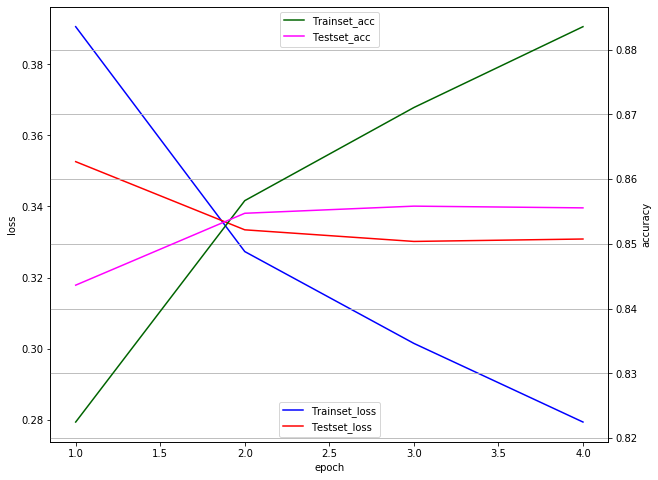

In [35]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()